In [49]:
import pandas as pd
from IPython.display import Image
import json
import warnings
warnings.filterwarnings('ignore')
from catboost import CatBoostClassifier
%matplotlib inline

In [50]:
import os
data_path = os.path.abspath('..')+'/data/'
data_path

'/Users/benjibred/Projects/Python/PokeApi-with-Superlinked/data/'

Let us get basic understanding about the data

In [51]:
pokedex_df = pd.read_csv(data_path+"pokedex.csv").drop(columns=["Unnamed: 0"])
pokedex_df.head()

,id,name,abilities,color,shape,habitat,capture_chance,height,weight,poke_type,sprite
0,1,bulbasaur,"['overgrow', 'chlorophyll']",green,quadruped,grassland,0.18,7,69,grass,https://raw.githubusercontent.com/PokeAPI/spri...
1,2,ivysaur,"['overgrow', 'chlorophyll']",green,quadruped,grassland,0.18,10,130,grass,https://raw.githubusercontent.com/PokeAPI/spri...
2,3,venusaur,"['overgrow', 'chlorophyll']",green,quadruped,grassland,0.18,20,1000,grass,https://raw.githubusercontent.com/PokeAPI/spri...
3,4,charmander,"['blaze', 'solar-power']",red,upright,mountain,0.18,6,85,fire,https://raw.githubusercontent.com/PokeAPI/spri...
4,5,charmeleon,"['blaze', 'solar-power']",red,upright,mountain,0.18,11,190,fire,https://raw.githubusercontent.com/PokeAPI/spri...


In [52]:
pokedex_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              1025 non-null   int64  
 1   name            1025 non-null   object 
 2   abilities       1025 non-null   object 
 3   color           1025 non-null   object 
 4   shape           905 non-null    object 
 5   habitat         386 non-null    object 
 6   capture_chance  1025 non-null   float64
 7   height          1025 non-null   int64  
 8   weight          1025 non-null   int64  
 9   poke_type       1025 non-null   object 
 10  sprite          1025 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 88.2+ KB


In [53]:
pokedex_df['shape'].value_counts()

upright      190
quadruped    169
humanoid     137
wings         80
arms          48
ball          42
fish          41
armor         40
blob          38
squiggle      37
legs          23
tentacles     23
bug-wings     21
heads         16
Name: shape, dtype: int64

In [54]:
pokedex_df['habitat'].value_counts()

grassland        80
forest           71
waters-edge      47
mountain         45
sea              40
urban            37
cave             29
rough-terrain    27
rare             10
Name: habitat, dtype: int64

We see that shape and habitat columns contain lots of nulls. So the mission is to fill nulls in a elegant way. It should be noted that classes are imbalanced.
So the data preparation begins with cleaning and transforming the data. Abilities column are a strings so we transform it into list.

In [55]:
pokedex_df['abilities'] = pokedex_df['abilities'].str.replace("'",'''"''').apply(json.loads)

Next, we will transform abilities column into separate columns for each ability. We want to differentiate those pokemons who have one, two or three abilities. 

In [56]:
df_pred_habitat = pokedex_df['abilities'].apply(pd.Series)
df_pred_habitat = df_pred_habitat.rename(columns = lambda x : 'ability' + '_' + str(x))

In [57]:
df_pred_habitat

,ability_0,ability_1,ability_2
0,overgrow,chlorophyll,NaN
1,overgrow,chlorophyll,NaN
2,overgrow,chlorophyll,NaN
3,blaze,solar-power,NaN
4,blaze,solar-power,NaN
...,...,...,...
1020,protosynthesis,NaN,NaN
1021,quark-drive,NaN,NaN
1022,quark-drive,NaN,NaN
1023,tera-shift,NaN,NaN


Here we prepare df to predict habitat. We will use color, capture_chance, height, weight and all three abilities columns as features.

In [58]:
df_pred_habitat = pd.concat([df_pred_habitat, pokedex_df['color'], pokedex_df['capture_chance'],
                pokedex_df['height'], pokedex_df['weight'], pokedex_df['habitat'], pokedex_df['poke_type']],axis=1)

In [59]:
df_pred_habitat['ability_1'].fillna('None', inplace=True)
df_pred_habitat['ability_2'].fillna('None', inplace=True)

In [60]:
df_pred_habitat

,ability_0,ability_1,ability_2,color,capture_chance,height,weight,habitat,poke_type
0,overgrow,chlorophyll,None,green,0.18,7,69,grassland,grass
1,overgrow,chlorophyll,None,green,0.18,10,130,grassland,grass
2,overgrow,chlorophyll,None,green,0.18,20,1000,grassland,grass
3,blaze,solar-power,None,red,0.18,6,85,mountain,fire
4,blaze,solar-power,None,red,0.18,11,190,mountain,fire
...,...,...,...,...,...,...,...,...,...
1020,protosynthesis,None,None,yellow,0.04,52,4800,NaN,electric
1021,quark-drive,None,None,gray,0.04,15,1625,NaN,rock
1022,quark-drive,None,None,blue,0.04,16,1560,NaN,steel
1023,tera-shift,None,None,blue,1.00,2,65,NaN,normal


Before us multi-classification problem with lots of unique non-ordinal categorical features. The best choice is to use CatBoostClassifier from CatBoost library. The classes are imbalanced, so we will use 'Balanced' option in CatBoostClassifier.

In [61]:
X = df_pred_habitat[df_pred_habitat['habitat'].notna()].drop(columns='habitat')
y = df_pred_habitat[df_pred_habitat['habitat'].notna()]['habitat']
pred_data = df_pred_habitat[df_pred_habitat['habitat'].isna()].drop(columns='habitat')

cat_vars = [var for var in X.columns if X[var].dtype == "O"]
model = CatBoostClassifier(iterations=500, depth=10, learning_rate=0.1, loss_function='MultiClass', cat_features=cat_vars, auto_class_weights='Balanced')

model.fit(X, y)
predictions_pd = pd.DataFrame({'habitat':[x[0] for x in model.predict(pred_data)]})

0:	learn: 2.1301812	total: 97.3ms	remaining: 48.5s
1:	learn: 2.0761671	total: 182ms	remaining: 45.3s
2:	learn: 2.0224072	total: 290ms	remaining: 48.1s
3:	learn: 1.9743308	total: 410ms	remaining: 50.9s
4:	learn: 1.9180128	total: 422ms	remaining: 41.8s
5:	learn: 1.8725633	total: 489ms	remaining: 40.2s
6:	learn: 1.8300882	total: 558ms	remaining: 39.3s
7:	learn: 1.7947998	total: 641ms	remaining: 39.4s
8:	learn: 1.7544305	total: 719ms	remaining: 39.2s
9:	learn: 1.7173994	total: 832ms	remaining: 40.8s
10:	learn: 1.6835264	total: 981ms	remaining: 43.6s
11:	learn: 1.6442820	total: 1.01s	remaining: 41s
12:	learn: 1.6097941	total: 1.11s	remaining: 41.5s
13:	learn: 1.5772682	total: 1.13s	remaining: 39.3s
14:	learn: 1.5439283	total: 1.23s	remaining: 39.7s
15:	learn: 1.5023591	total: 1.3s	remaining: 39.3s
16:	learn: 1.4848895	total: 1.3s	remaining: 36.9s
17:	learn: 1.4550343	total: 1.39s	remaining: 37.1s
18:	learn: 1.4255149	total: 1.56s	remaining: 39.6s
19:	learn: 1.4037631	total: 1.76s	remaining:

In [62]:
pred_data.reset_index(drop=True, inplace=True)
temp_pd = pd.concat([pred_data, predictions_pd], axis=1)

df_predicted_habitat = pd.concat([df_pred_habitat[df_pred_habitat['habitat'].notna()], temp_pd], axis=0)
df_predicted_habitat.reset_index(drop=True, inplace=True)

And we do the same to predict shape.

In [63]:
df_pred_shape = pd.concat([df_predicted_habitat, pokedex_df['shape']], axis=1)

X = df_pred_shape[df_pred_shape['shape'].notna()].drop(columns='shape')
y = df_pred_shape[df_pred_shape['shape'].notna()]['shape']
pred_data = df_pred_shape[df_pred_shape['shape'].isna()].drop(columns='shape')

cat_vars = [var for var in X.columns if X[var].dtype == "O"]
model = CatBoostClassifier(iterations=500, depth=10, learning_rate=0.1, loss_function='MultiClass', cat_features=cat_vars, auto_class_weights='Balanced')

model.fit(X, y)
predictions_pd = pd.DataFrame({'shape':[x[0] for x in model.predict(pred_data)]})

0:	learn: 2.5881278	total: 438ms	remaining: 3m 38s
1:	learn: 2.5562930	total: 447ms	remaining: 1m 51s
2:	learn: 2.5006885	total: 725ms	remaining: 2m
3:	learn: 2.4531742	total: 961ms	remaining: 1m 59s
4:	learn: 2.4085830	total: 1.46s	remaining: 2m 25s
5:	learn: 2.3626460	total: 1.87s	remaining: 2m 34s
6:	learn: 2.3273527	total: 2.26s	remaining: 2m 39s
7:	learn: 2.2800371	total: 2.73s	remaining: 2m 47s
8:	learn: 2.2347846	total: 3.06s	remaining: 2m 47s
9:	learn: 2.2112730	total: 3.1s	remaining: 2m 32s
10:	learn: 2.1752146	total: 3.65s	remaining: 2m 42s
11:	learn: 2.1602092	total: 3.67s	remaining: 2m 29s
12:	learn: 2.1235448	total: 4.03s	remaining: 2m 30s
13:	learn: 2.0865922	total: 4.47s	remaining: 2m 35s
14:	learn: 2.0541980	total: 4.83s	remaining: 2m 36s
15:	learn: 2.0253474	total: 5.22s	remaining: 2m 37s
16:	learn: 1.9909801	total: 5.63s	remaining: 2m 39s
17:	learn: 1.9546023	total: 6.08s	remaining: 2m 42s
18:	learn: 1.9239489	total: 6.48s	remaining: 2m 44s
19:	learn: 1.8937129	total:

In [64]:
pred_data.reset_index(drop=True, inplace=True)
temp_pd = pd.concat([pred_data, predictions_pd], axis=1)

df_predicted_shape = pd.concat([df_pred_shape[df_pred_shape['shape'].notna()], temp_pd], axis=0)
df_predicted_shape.reset_index(drop=True, inplace=True)

In [65]:
df_pred_shape

,ability_0,ability_1,ability_2,color,capture_chance,height,weight,habitat,poke_type,shape
0,overgrow,chlorophyll,None,green,0.18,7,69,grassland,grass,quadruped
1,overgrow,chlorophyll,None,green,0.18,10,130,grassland,grass,quadruped
2,overgrow,chlorophyll,None,green,0.18,20,1000,grassland,grass,quadruped
3,blaze,solar-power,None,red,0.18,6,85,mountain,fire,upright
4,blaze,solar-power,None,red,0.18,11,190,mountain,fire,upright
...,...,...,...,...,...,...,...,...,...,...
1020,protosynthesis,None,None,yellow,0.04,52,4800,grassland,electric,NaN
1021,quark-drive,None,None,gray,0.04,15,1625,mountain,rock,NaN
1022,quark-drive,None,None,blue,0.04,16,1560,rough-terrain,steel,NaN
1023,tera-shift,None,None,blue,1.00,2,65,grassland,normal,NaN


In [66]:
sprite = pokedex_df['sprite']
name = pokedex_df['name']
id = pokedex_df['id']
pokedex_df = pd.concat([df_predicted_shape, sprite, name, id], axis=1)
pokedex_df = pokedex_df[['id', 'name', 'color', 'habitat', 'shape', 'poke_type', 'capture_chance', 'height','weight', 'ability_0','ability_1', 'ability_2', 'sprite']]
pokedex_df.to_csv(data_path+"pokedex_updated.csv")

Here we save the updated dataframe. This dataframe does not contain any null values. And ready to be used for further analysis. 

In [67]:
pokedex_df.head(5)

,id,name,color,habitat,shape,poke_type,capture_chance,height,weight,ability_0,ability_1,ability_2,sprite
0,1,bulbasaur,green,grassland,quadruped,grass,0.18,7,69,overgrow,chlorophyll,None,https://raw.githubusercontent.com/PokeAPI/spri...
1,2,ivysaur,green,grassland,quadruped,grass,0.18,10,130,overgrow,chlorophyll,None,https://raw.githubusercontent.com/PokeAPI/spri...
2,3,venusaur,green,grassland,quadruped,grass,0.18,20,1000,overgrow,chlorophyll,None,https://raw.githubusercontent.com/PokeAPI/spri...
3,4,charmander,red,mountain,upright,fire,0.18,6,85,blaze,solar-power,None,https://raw.githubusercontent.com/PokeAPI/spri...
4,5,charmeleon,red,mountain,upright,fire,0.18,11,190,blaze,solar-power,None,https://raw.githubusercontent.com/PokeAPI/spri...


In [68]:
pokedex_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              1025 non-null   int64  
 1   name            1025 non-null   object 
 2   color           1025 non-null   object 
 3   habitat         1025 non-null   object 
 4   shape           1025 non-null   object 
 5   poke_type       1025 non-null   object 
 6   capture_chance  1025 non-null   float64
 7   height          1025 non-null   int64  
 8   weight          1025 non-null   int64  
 9   ability_0       1025 non-null   object 
 10  ability_1       1025 non-null   object 
 11  ability_2       1025 non-null   object 
 12  sprite          1025 non-null   object 
dtypes: float64(1), int64(3), object(9)
memory usage: 104.2+ KB


To see the distribution we draw the bars

<AxesSubplot:>

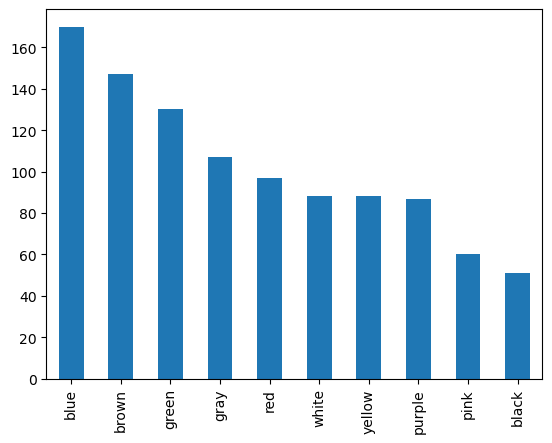

In [69]:
pokedex_df['color'].value_counts().plot.bar()

We can compare our shape prediction with pokemon.fandom. Check https://pokemon.fandom.com/wiki/List_of_Pok%C3%A9mon_by_shape.

<AxesSubplot:>

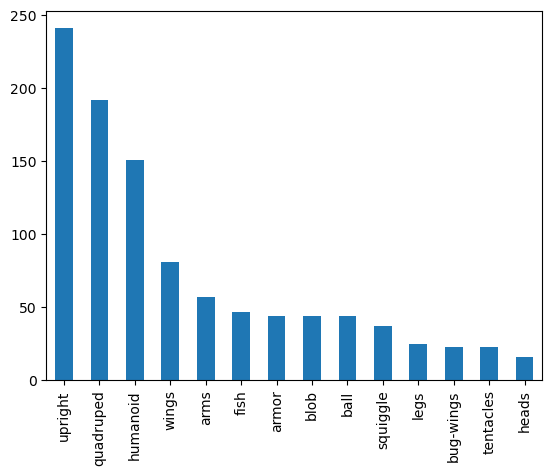

In [70]:
pokedex_df['shape'].value_counts().plot.bar()

The habitat distribution looks alike to what we see on bulbapedia (assuming they provide data according to the descending order). Check https://bulbapedia.bulbagarden.net/wiki/List_of_Pok%C3%A9mon_by_habitat.

<AxesSubplot:>

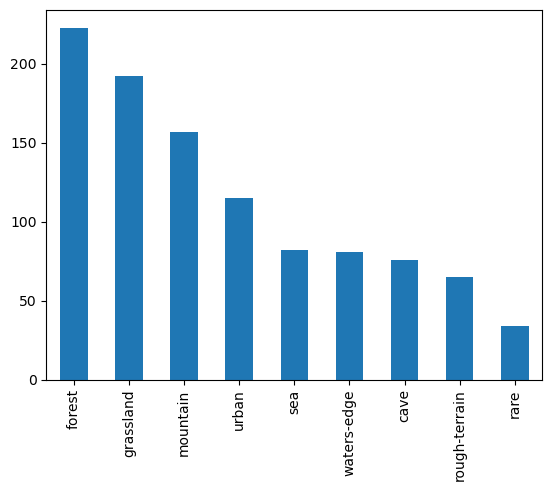

In [71]:
pokedex_df['habitat'].value_counts().plot.bar()

<AxesSubplot:>

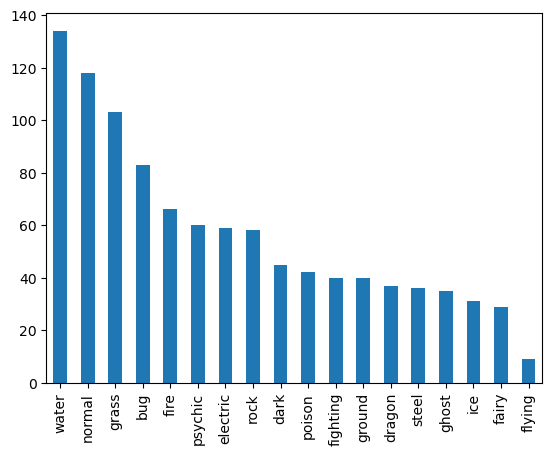

In [87]:
pokedex_df['poke_type'].value_counts().plot.bar()

The biggest pokemon:

In [72]:
max_height = pokedex_df['height'].max()
pokedex_df.query(f'height == {max_height}')

,id,name,color,habitat,shape,poke_type,capture_chance,height,weight,ability_0,ability_1,ability_2,sprite
889,890,eternatus,purple,grassland,wings,poison,1.0,200,9500,pressure,None,None,https://raw.githubusercontent.com/PokeAPI/spri...


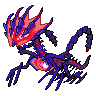

In [79]:
Image(pokedex_df.at[889, 'sprite'])

The heaviest pokemon:

In [74]:
max_weight = pokedex_df['weight'].max()
pokedex_df.query(f'weight == {max_weight}')

,id,name,color,habitat,shape,poke_type,capture_chance,height,weight,ability_0,ability_1,ability_2,sprite
789,790,cosmoem,blue,rare,ball,psychic,0.18,1,9999,sturdy,None,None,https://raw.githubusercontent.com/PokeAPI/spri...
796,797,celesteela,green,mountain,humanoid,steel,0.18,92,9999,beast-boost,None,None,https://raw.githubusercontent.com/PokeAPI/spri...


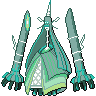

In [83]:
Image(pokedex_df.at[796, 'sprite'])

The smallest pokemon:

In [ ]:
min_height = pokedex_df['height'].min()
pokedex_df.query(f'height == {min_height}')

The lightest pokemon:

In [84]:
min_weight = pokedex_df['weight'].min()
pokedex_df.query(f'weight == {min_weight}')

,id,name,color,habitat,shape,poke_type,capture_chance,height,weight,ability_0,ability_1,ability_2,sprite
91,92,gastly,purple,cave,ball,ghost,0.75,13,1,levitate,None,None,https://raw.githubusercontent.com/PokeAPI/spri...
92,93,haunter,purple,cave,arms,ghost,0.35,16,1,levitate,None,None,https://raw.githubusercontent.com/PokeAPI/spri...
668,669,flabebe,white,grassland,arms,fairy,0.88,1,1,flower-veil,symbiosis,None,https://raw.githubusercontent.com/PokeAPI/spri...
788,789,cosmog,blue,cave,ball,psychic,0.18,2,1,unaware,None,None,https://raw.githubusercontent.com/PokeAPI/spri...
797,798,kartana,white,grassland,humanoid,grass,0.18,3,1,beast-boost,None,None,https://raw.githubusercontent.com/PokeAPI/spri...


Hardest to catch pokemon:

In [85]:
lowest_capture_chance = pokedex_df['capture_chance'].min()
pokedex_df.query(f'capture_chance == {lowest_capture_chance}')

,id,name,color,habitat,shape,poke_type,capture_chance,height,weight,ability_0,ability_1,ability_2,sprite
143,144,articuno,blue,rare,wings,ice,0.01,17,554,pressure,snow-cloak,None,https://raw.githubusercontent.com/PokeAPI/spri...
144,145,zapdos,yellow,rare,wings,electric,0.01,16,526,pressure,static,None,https://raw.githubusercontent.com/PokeAPI/spri...
145,146,moltres,yellow,rare,wings,fire,0.01,20,600,pressure,flame-body,None,https://raw.githubusercontent.com/PokeAPI/spri...
149,150,mewtwo,purple,rare,upright,psychic,0.01,20,1220,pressure,unnerve,None,https://raw.githubusercontent.com/PokeAPI/spri...
242,243,raikou,yellow,grassland,quadruped,electric,0.01,19,1780,pressure,inner-focus,None,https://raw.githubusercontent.com/PokeAPI/spri...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007,1008,miraidon,blue,cave,quadruped,electric,0.01,35,2400,hadron-engine,hadron-engine,None,https://raw.githubusercontent.com/PokeAPI/spri...
1013,1014,okidogi,black,cave,upright,poison,0.01,18,922,toxic-chain,guard-dog,None,https://raw.githubusercontent.com/PokeAPI/spri...
1014,1015,munkidori,black,grassland,arms,poison,0.01,10,122,toxic-chain,frisk,None,https://raw.githubusercontent.com/PokeAPI/spri...
1015,1016,fezandipiti,black,grassland,upright,poison,0.01,14,301,toxic-chain,technician,None,https://raw.githubusercontent.com/PokeAPI/spri...


Easiest to catch pokemon:

In [86]:
highest_capture_chance = pokedex_df['capture_chance'].max()
pokedex_df.query(f'capture_chance == {highest_capture_chance}')

,id,name,color,habitat,shape,poke_type,capture_chance,height,weight,ability_0,ability_1,ability_2,sprite
9,10,caterpie,green,forest,armor,bug,1.0,3,29,shield-dust,run-away,None,https://raw.githubusercontent.com/PokeAPI/spri...
12,13,weedle,brown,forest,armor,bug,1.0,3,32,shield-dust,run-away,None,https://raw.githubusercontent.com/PokeAPI/spri...
15,16,pidgey,brown,forest,wings,normal,1.0,3,18,keen-eye,tangled-feet,big-pecks,https://raw.githubusercontent.com/PokeAPI/spri...
18,19,rattata,purple,grassland,quadruped,normal,1.0,3,35,run-away,guts,hustle,https://raw.githubusercontent.com/PokeAPI/spri...
20,21,spearow,brown,rough-terrain,wings,normal,1.0,3,20,keen-eye,sniper,None,https://raw.githubusercontent.com/PokeAPI/spri...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,917,tarountula,white,forest,armor,bug,1.0,3,40,insomnia,stakeout,None,https://raw.githubusercontent.com/PokeAPI/spri...
927,928,smoliv,green,forest,upright,grass,1.0,3,65,early-bird,harvest,None,https://raw.githubusercontent.com/PokeAPI/spri...
931,932,nacli,brown,mountain,legs,rock,1.0,4,160,purifying-salt,sturdy,clear-body,https://raw.githubusercontent.com/PokeAPI/spri...
959,960,wiglett,white,sea,blob,water,1.0,12,18,gooey,rattled,sand-veil,https://raw.githubusercontent.com/PokeAPI/spri...
